這邊用來存程式碼
===
請善用Ctrl+F來查詢所需函式或程式碼
---
下載完DATA記得改img路徑<br>
懶得改就直接丟C槽 <font color="red">然後資料夾名稱flowerpic</font><br>
因為我如果全部推github 要很久== 你們下載會更久:)

訓練集(DATA):https://www.kaggle.com/datasets/msheriey/104-flowers-garden-of-eden

訓練辨識系統
---


In [1]:
#import 丟這裡
#no moudle 請在終端機 pip install moudle 或是 python -m pip install moudle

import pandas as pd
import numpy as np
import cv2
import os
from PIL import Image
import math
import matplotlib.pyplot as plt
from pathlib import Path
import requests
import re
import time
from selenium import webdriver

In [2]:
#HSV即色相、飽和度、明度
#https://zh.wikipedia.org/zh-tw/HSL%E5%92%8CHSV%E8%89%B2%E5%BD%A9%E7%A9%BA%E9%97%B4
##看顏色##
#https://www.peko-step.com/zhtw/tool/hsvrgb.html
# img="testdata/1515.jpeg"
# img=cv2.imread(img)
# img=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

# cv2.imwrite('oxx3.jpeg', img)
# cv2.waitKey(0)                              
# cv2.destroyAllWindows()



PS 中

H 範圍在 0 ~ 360 。 S 範圍在 0 ~ 1 % V 範圍在 0 ~ 1 %

Python 中

H 範圍在 0 ~ 180 S 範圍在 0 ~ 255 V 範圍在 0 ~ 255

In [3]:
#顏色區分
#論文pg21 有空幫我看一下我有沒有寫錯 謝謝
HSV=[114, 134, 181]
HSV=np.array(HSV)
def HSV_differentiate(HSV):
    h=HSV[0]*2
    s=HSV[1]*100/255
    v=HSV[2]*100/255
    if  v<20:
        l=0
    elif s<20 and 20<=v<80 :
        l=math.floor(((v/100-0.2)*10))+1   
    elif s<20 and 80<=v<=100:
        l=7
    else:
        if h>22 and h<=45:
            H=1
        elif h>45 and h<=70:
            H=2
        elif h>70 and h<=155:
            H=3
        elif h>155 and h<=186:
            H=4
        elif h>186 and h<=278:
            H=5
        elif h>278 and h<=330:
            H=6
        else:H=0
        if s>20 and s<=65:
            S=0
        else:S=1
        if v>20 and v<=70:
            V=0
        else:V=1
        l=4*H+2*S+V+8
    return l

print(HSV_differentiate(HSV))

29


In [4]:
#像素
224*224

50176

In [5]:
#畫出圓形區域
def Centroid(img):
    img = cv2.imread(img)
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray_image,127,255,0)
    M = cv2.moments(thresh)
    #質心
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    
    if cX>cY:
        radius=cY-1
    else:radius=cX-1
        
    cv2.circle(img, (cX, cY), 2, (255, 255, 255), -1)
    cv2.circle(img, (cX, cY), radius,(255, 255, 255), 0)
    cv2.circle(img, (cX, cY), radius//3,(255, 255, 255), 0)
    cv2.circle(img, (cX, cY), radius*2//3,(255, 255, 255), 0)
 

    return ((cX,cY))
Centroid("C:/flowerpic/jpeg-224x224/val/iris/12769.jpeg")

Centroid("testdata/balloon flower_2.jpeg")


(95, 135)

In [6]:
##質心半徑
def Radius(img):
    img = cv2.imread(img)
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray_image,127,255,0)
    M = cv2.moments(thresh)
    #質心
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    
    if cX>cY:
        radius=cY-1
    else:radius=cX-1
    
    return radius
print(Radius("C:/flowerpic/jpeg-224x224/val/iris/12769.jpeg"))
print(Radius("C:/flowerpic/jpeg-224x224/val/iris/16301.jpeg"))

110
103


In [7]:
#切割圓形區域


def Cut(img):
    name=img.split("/")
    
    img_=cv2.imread(img)
    img1=cv2.imread((img))
    img2=cv2.imread((img))
    img3=cv2.imread((img))
    #質心半徑
    r=Radius(img)
    ##遮蓋罩##
    ##最大
    #MASK1=np.zeros_like(img1)
    MASK1=np.zeros((img1.shape[0], img1.shape[1]), dtype=np.uint8) 
    cv2.circle(MASK1, (111,124), r, (255, 255, 255), -1) 
    ##次之
    #MASK2=np.zeros_like(img2)
    MASK2=np.zeros((img2.shape[0], img2.shape[1]), dtype=np.uint8) 
    cv2.circle(MASK2, (111,124), r*2//3, (255, 255, 255), -1)

    ##最小 
    #MASK3=np.zeros_like(img3)
    MASK3=np.zeros((img3.shape[0], img3.shape[1]), dtype=np.uint8) 
    cv2.circle(MASK3, (111,124), r//3, (255, 255, 255), -1)
    mask2 = cv2.subtract(MASK2, MASK3)
    mask1 = cv2.subtract(MASK1, MASK2)
    
    imgAddMask1 = cv2.add(img1, np.zeros(np.shape(img1), dtype=np.uint8), mask=mask1)
    imgAddMask2 = cv2.add(img2, np.zeros(np.shape(img2), dtype=np.uint8), mask=mask2)
    imgAddMask3 = cv2.add(img3, np.zeros(np.shape(img3), dtype=np.uint8), mask=MASK3)
    cv2.imwrite("cuts/cut1_"+name[-2]+"_"+name[-1], imgAddMask1)
    cv2.imwrite("cuts/cut2_"+name[-2]+"_"+name[-1], imgAddMask2)
    cv2.imwrite("cuts/cut3_"+name[-2]+"_"+name[-1], imgAddMask3)
    
    
Cut("C:/flowerpic/jpeg-224x224/val/iris/12769.jpeg")
Cut("C:/flowerpic/jpeg-224x224/val/iris/16301.jpeg")
# r=110

# img="C:/flowerpic/jpeg-224x224/val/iris/12769.jpeg"
# img_=cv2.imread(img)
# img1 = cv2.imread(img)
# img2 = cv2.imread(img)
# img3 = cv2.imread(img)

# ##最大
# #MASK1=np.zeros_like(img1)
# MASK1=np.zeros((img1.shape[0], img1.shape[1]), dtype=np.uint8) 
# cv2.circle(MASK1, (111,124), r, (255, 255, 255), -1) 
# ##次之
# #MASK2=np.zeros_like(img2)
# MASK2=np.zeros((img2.shape[0], img2.shape[1]), dtype=np.uint8) 
# cv2.circle(MASK2, (111,124), r*2//3, (255, 255, 255), -1)

# ##最小 
# #MASK3=np.zeros_like(img3)
# MASK3=np.zeros((img3.shape[0], img3.shape[1]), dtype=np.uint8) 
# cv2.circle(MASK3, (111,124), r//3, (255, 255, 255), -1)

# mask2 = cv2.subtract(MASK2, MASK3)
# mask1 = cv2.subtract(MASK1, MASK2)
# # # ROI
# # result2 = cv2.cvtColor(img2, cv2.COLOR_BGR2BGRA)
# # result2[:, :, 3] = mask2[:,:,0]
# # #cv2.imshow('image', result2)
# # #cv2.imshow('mask2', mask2)
# # cv2.imwrite('result2.png', result2)

# # result1 = cv2.cvtColor(img1, cv2.COLOR_BGR2BGRA)
# # result1[:, :, 3] = mask1[:,:,0]
# # #cv2.imshow('image', result1)
# # #cv2.imshow('mask1', mask1)
# # cv2.imwrite('result1.png', result1)

# # result3 = cv2.cvtColor(img3, cv2.COLOR_BGR2BGRA)
# # result3[:, :, 3] = MASK3[:,:,0]
# # #cv2.imshow('image', result3)
# # #cv2.imshow('mask3', MASK3)
# # cv2.imwrite('result3.png', result3)

# imgAddMask1 = cv2.add(img1, np.zeros(np.shape(img1), dtype=np.uint8), mask=mask1)
# imgAddMask2 = cv2.add(img2, np.zeros(np.shape(img2), dtype=np.uint8), mask=mask2)
# imgAddMask3 = cv2.add(img3, np.zeros(np.shape(img3), dtype=np.uint8), mask=MASK3)
# cv2.imshow("circularMask", mask1)  
# cv2.imshow("circularROI", imgAddMask1)
# cv2.imshow("circularMask2", mask2)  
# cv2.imshow("circularROI2", imgAddMask2)
# cv2.imshow("circularMask3", MASK3)  
# cv2.imshow("circularROI3", imgAddMask3)
# cv2.imwrite('cut1.jpeg', imgAddMask1)
# cv2.imwrite('cut2.jpeg', imgAddMask2)
# cv2.imwrite('cut3.jpeg', imgAddMask3)
# cv2.waitKey()
# cv2.destroyAllWindows()

In [8]:
#色彩直方圖
  
def Color_hist(cut1,cut2,cut3):
    img1 = cv2.imread(cut1)
    img2 = cv2.imread(cut2)
    img3 = cv2.imread(cut3)
    
    img1_=cv2.cvtColor(img1,cv2.COLOR_BGR2HSV)
    img2_=cv2.cvtColor(img2,cv2.COLOR_BGR2HSV)
    img3_=cv2.cvtColor(img3,cv2.COLOR_BGR2HSV)
    
    ##刪除純黑## 
    black=np.array([0,0,0])
    color_list_1_no_black=[]
    color_list_2_no_black=[]
    color_list_3_no_black=[]
    
    for i in img1_:
        for k in i:
            if k.any() == black.any():
                continue
            else:
                color_list_1_no_black.append(k)
                #print(k)
    for i in img2_:
        for k in i:
            if k.any() == black.any():
                continue
            else:
                color_list_2_no_black.append(k)
                #print(k)
    for i in img3_:
        for k in i:
            if k.any() == black.any():
                continue
            else:
                color_list_3_no_black.append(k)
                #print(k)    

    color_hist_1=[]
    for i in color_list_1_no_black:
        color_hist_1.append(HSV_differentiate(i))
    #plt.subplot(131) 
    #plt.hist(color_hist_1)

    color_hist_2=[]
    for i in color_list_2_no_black:
        color_hist_2.append(HSV_differentiate(i))
    #plt.subplot(132) 
    #plt.hist(color_hist_2)


    color_hist_3=[]
    for i in color_list_3_no_black:
        color_hist_3.append(HSV_differentiate(i))
    #plt.subplot(133) 
    #plt.hist(color_hist_3)
    for i in color_hist_1:
        if i==0:
            color_hist_1.remove(i)
        else: continue
    for i in color_hist_2:
        if i==0:
            color_hist_2.remove(i)
        else: continue
    for i in color_hist_3:
        if i==0:
            color_hist_3.remove(i)
        else: continue
    all_hist=[]
    all_hist=color_hist_1
    for i in color_hist_2:
        all_hist.append(i+35)
    for i in color_hist_3:
        all_hist.append(i+70)
    
    
    
    return all_hist
all_hist_1=Color_hist('cuts/cut1_iris_12769.jpeg','cuts/cut2_iris_12769.jpeg','cuts/cut3_iris_12769.jpeg')   
all_hist_2=Color_hist('cuts/cut1_iris_16301.jpeg','cuts/cut2_iris_16301.jpeg','cuts/cut3_iris_16301.jpeg')  
# img1 = cv2.imread("cut1_iris_12769.jpeg")
# img2 = cv2.imread("cut2_iris_12769.jpeg")
# img3 = cv2.imread("cut3_iris_12769.jpeg")
# #cv2.imshow('result3.png',img2)
# ##no change
# img1_=cv2.cvtColor(img1,cv2.COLOR_BGR2HSV)
# img2_=cv2.cvtColor(img2,cv2.COLOR_BGR2HSV)
# img3_=cv2.cvtColor(img3,cv2.COLOR_BGR2HSV)
# #cv2.imshow('result3.png',img2_)
# cv2.waitKey()
# cv2.destroyAllWindows()
# ##刪除純黑## 

# black=np.array([0,0,0])
# color_list_1_no_black=[]
# color_list_2_no_black=[]
# color_list_3_no_black=[]
# #color_list_1_no_black=np.ndarray(color_list_1_no_black)


# for i in img1_:
#     for k in i:
#         if k.any() == black.any():
#             continue
#         else:
#             color_list_1_no_black.append(k)
#             #print(k)
# for i in img2_:
#     for k in i:
#         if k.any() == black.any():
#             continue
#         else:
#             color_list_2_no_black.append(k)
#             #print(k)
# for i in img3_:
#     for k in i:
#         if k.any() == black.any():
#             continue
#         else:
#             color_list_3_no_black.append(k)
#             #print(k)    

# color_hist_1=[]
# for i in color_list_1_no_black:
#     color_hist_1.append(HSV_differentiate(i))
# plt.subplot(131) 
# plt.hist(color_hist_1)

# color_hist_2=[]
# for i in color_list_2_no_black:
#     color_hist_2.append(HSV_differentiate(i))
# plt.subplot(132) 
# plt.hist(color_hist_2)


# color_hist_3=[]
# for i in color_list_3_no_black:
#     color_hist_3.append(HSV_differentiate(i))
# plt.subplot(133) 
# plt.hist(color_hist_3)


# # color_list_1=[]
# # for i in img1:
# #     for k in i:
# #         color_list_1.append(HSV_differentiate(k))

# # color_list_1
# # plt.subplot(131)    
# # plt.hist(color_list_1)
# # color_list_2=[]
# # for i in img2:
# #     for k in i:
# #         color_list_2.append(HSV_differentiate(k))

# # color_list_2 
# # plt.subplot(132)      
# # plt.hist(color_list_2)
# # color_list_3=[]
# # for i in img3:
# #     for k in i:
# #         color_list_3.append(HSV_differentiate(k))

# # color_list_3    
# # plt.subplot(133)   
# # plt.hist(color_list_3)


* 相關性比較<br>
0~1 越大相關性越高
* 巴氏距離<br>
0~1 越小相關度越高<br>
參考:http://shichaoxin.com/2021/08/27/OpenCV%E5%9F%BA%E7%A1%80-%E7%AC%AC%E4%BA%8C%E5%8D%81%E4%B8%89%E8%AF%BE-%E7%9B%B4%E6%96%B9%E5%9B%BE%E6%AF%94%E8%BE%83/

(0.4706269551142173, 0.4898952958061212)

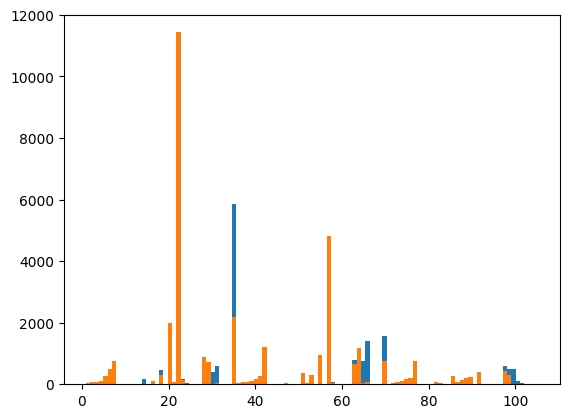

In [9]:
##直方圖交集



def Compare_Hist(h1,h2):
    #H1=plt.hist(h1,36,(0,36))
    #H2=plt.hist(h2,36,(0,36))

    #H1_array=h1[0]
    H1_array=h1[:,np.newaxis]
    #H2_array=h2[0]
    H2_array=h2[:,np.newaxis]
    H1_array=np.float32(H1_array)
    H2_array=np.float32(H2_array)
    corr=(cv2.compareHist(H1_array,H2_array , method=0))#HISTCMP_CORREL
    dis=(cv2.compareHist(H1_array,H2_array , method=cv2.HISTCMP_BHATTACHARYYA))#巴氏距離
    
    return corr ,dis
Compare_Hist(plt.hist(all_hist_1,105,(1,105))[0],plt.hist(all_hist_2,105,(1,105))[0])


資料庫
===

In [10]:
# title={
#     "id":[],
#     'name_En':[],
#     #'name_Ch':[],
#     'color_hist_1':[],
#     'color_hist_2':[],
#     'color_hist_3':[]
    
# }
title={
    "id":[],
    'name_En':[],
    #'name_Ch':[],
    'color_hist':[],

    
}
def GetId(img):
    name=img.split("/")
    ID=name[-1][:-5]
    return ID

def GetName(img):
    name=img.split("/")
    Name=name[-2]
    return Name
flower_db=pd.DataFrame(title)
flower_db

,id,name_En,color_hist


finish


{'id': '12769',
 'name_En': 'iris',
 'color_hist': array([3.200e+01, 1.000e+01, 1.000e+00, 9.000e+00, 3.200e+01, 2.300e+01,
        2.200e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.810e+02, 5.000e+00, 4.000e+01, 3.000e+00, 4.660e+02,
        2.000e+01, 1.630e+02, 2.800e+01, 2.335e+03, 1.800e+02, 3.700e+01,
        2.000e+00, 0.000e+00, 2.000e+00, 6.030e+02, 3.960e+02, 3.850e+02,
        6.050e+02, 0.000e+00, 0.000e+00, 0.000e+00, 5.862e+03, 4.900e+01,
        3.100e+01, 2.600e+01, 6.000e+00, 1.300e+01, 1.500e+01, 5.000e+01,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.800e+01, 0.000e+00,
        2.000e+00, 0.000e+00, 2.840e+02, 1.100e+01, 3.000e+02, 2.200e+01,
        9.100e+01, 3.000e+00, 4.280e+02, 6.100e+01, 9.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 7.820e+02, 7.840e+02, 7.720e+02, 1.417e+03,
        3.000e+00, 0.000e+00, 0.000e+00, 1.558e+03, 1.300e+01, 7.000e+00,
        1.000e+01, 1.500e+01, 2.000e+01, 2.900e+01, 1.300e+02,

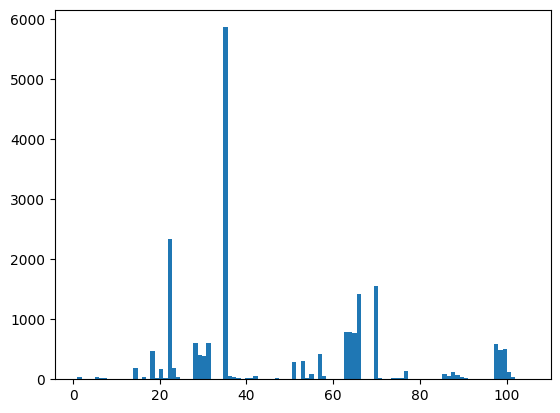

In [11]:

#"C:/flowerpic/jpeg-224x224/val/iris/12769.jpeg"
def To_Data(img):
    name=img.split("/")
    Cut(img)
    H=Color_hist("cuts/cut1_"+name[-2]+"_"+name[-1],
                        "cuts/cut2_"+name[-2]+"_"+name[-1],
                        "cuts/cut3_"+name[-2]+"_"+name[-1])
    
    
    # H1=plt.hist(H1,35,(1,36))
    # H2=plt.hist(H2,35,(1,36))
    # H3=plt.hist(H3,35,(1,36))
    HIST=plt.hist(H,105,(1,105))
    # data={
    # "id":GetId(img),
    # 'name_En':GetName(img),
    # 'color_hist_1':H1[0],
    # 'color_hist_2':H2[0],
    # 'color_hist_3':H3[0]
    # }
    data={
    "id":GetId(img),
    'name_En':GetName(img),
    #'name_Ch':[],
    'color_hist':HIST[0],

    
}

   
    
    #H2_remake=[]
    #H3_remake=[]
    #for i in H2:
        #H2_remake.append(i+"2")
    #for i in H3:
        #H3_remake.append(i+"2")
    #H=H1+H2_remake+H3_remake    
    print("finish")
    
    return data
To_Data("C:/flowerpic/jpeg-224x224/val/iris/12769.jpeg")


下面最好是不要跑 

finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish

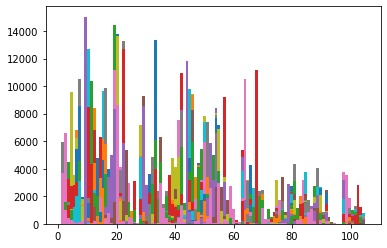

In [132]:
#flower_db=flower_db.append(To_Data("flower_pic/tree mallow/13651.jpeg"),ignore_index=True)
pathlist = Path("flower_pic").glob("**/*.jpeg")
myfile = "filename.txt"
for path in pathlist:
    Path_=(str(path).replace('\\','/'))
    flower_db=flower_db.append(To_Data(Path_),ignore_index=True)

In [133]:
flower_db.to_csv("flower_db.csv")

花朵比對
===

In [24]:
df=pd.read_csv("flower_db.csv")


In [27]:
##直方圖交集

#336 337

def Compare_Hist(h1,h2):
    #H1=plt.hist(h1,36,(0,36))
    #H2=plt.hist(h2,36,(0,36))

    #H1_array=h1[0]
    H1_array=h1[:,np.newaxis]
    #H2_array=h2[0]
    H2_array=h2[:,np.newaxis]
    H1_array=np.float32(H1_array)
    H2_array=np.float32(H2_array)
    corr=(cv2.compareHist(H1_array,H2_array , method=0))#HISTCMP_CORREL
    dis=(cv2.compareHist(H1_array,H2_array , method=cv2.HISTCMP_BHATTACHARYYA))#巴氏距離
    
    return corr ,dis

In [29]:
def ChangeType(x):
    x=x.replace('\n','')
    x=x.replace('[','')
    x=x.replace(']','')
    x=x.split(' ')
    x=np.array(x)
    x=x.astype(np.float64)
    return x

(0.36926034580227984, 0.5242356325329831)

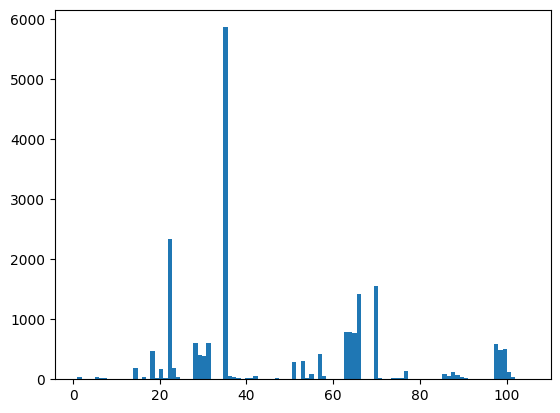

In [30]:
train=df["color_hist"][1]
train=ChangeType(train)
#test=ChangeType()
Compare_Hist(train,plt.hist(all_hist_1,105,(1,105))[0])
# # HIST=plt.hist(all_hist_1,105,(1,105))
# # HIST[0]

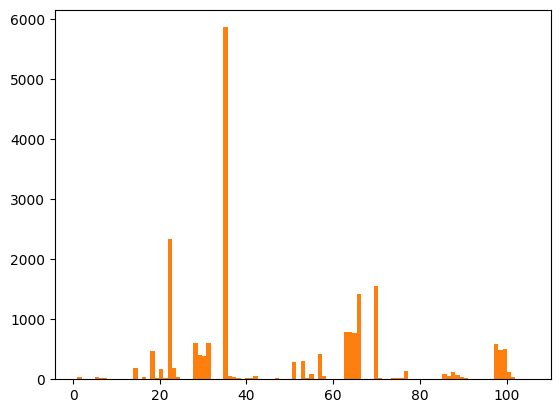

In [35]:
def CompareData(test_img):
        name=test_img.split("/")
        Cut(test_img)
        H=Color_hist("cuts/cut1_"+name[-2]+"_"+name[-1],
                        "cuts/cut2_"+name[-2]+"_"+name[-1],
                        "cuts/cut3_"+name[-2]+"_"+name[-1])
        
        HIST=plt.hist(H,105,(1,105))
        # H1=plt.hist(H1,35,(1,36))
        # H2=plt.hist(H2,35,(1,36))
        # H3=plt.hist(H3,35,(1,36))
        # title={
        # "num":[],

        # 'color_hist_1_corr':[],
        # 'color_hist_2_corr':[],
        # 'color_hist_3_corr':[],
        # 'color_hist_1_dis':[],
        # 'color_hist_2_dis':[],
        # 'color_hist_3_dis':[],
        # }
        title={
        "num":[],
        'color_hist_corr':[],
        'color_hist_dis':[]
     }
        compare_db=pd.DataFrame(title)
        for i in range(0,len(df)):
                try:
                        num=i
                        train=df["color_hist"][i]
                        train=ChangeType(train)
                        test=HIST[0]
                        
                        corr,dis=Compare_Hist(train,test)
                        
                        data={
                        "num":str(num),
                        'color_hist_corr':corr,
                        'color_hist_dis':dis}
                      
                        # train_1=df["color_hist_1"][i]
                        # train_1=ChangeType(train_1)
                        # test_1=H1[0]
                        # #test_1=ChangeType(test_1)
                        # #print(train_1)
                        # train_2=df["color_hist_2"][i]
                        # train_2=ChangeType(train_2)
                        # test_2=H2[0]
                        # #test_2=ChangeType(test_2)
                        
                        # train_3=df["color_hist_3"][i]
                        # train_3=ChangeType(train_3)
                        # test_3=H3[0]
                        # #test_3=ChangeType(test_3)
                                
                        # corr1,dis1=Compare_Hist(train_1,test_1)
                        
                        # corr2,dis2=Compare_Hist(train_2,test_2)
                        # corr3,dis3=Compare_Hist(train_3,test_3)
                        # data={
                        # "num":str(num),
                        # 'color_hist_1_corr':corr1,
                        # 'color_hist_2_corr':corr2,
                        # 'color_hist_3_corr':corr3,
                        # 'color_hist_1_dis':dis1,
                        # 'color_hist_2_dis':dis2,
                        # 'color_hist_3_dis':dis3,
                        #                         }
                        
                        compare_db=compare_db._append(data,ignore_index=True)      
                except:print('a')
        return compare_db
CompareData("C:/flowerpic/jpeg-224x224/val/iris/12769.jpeg")
compare_db=CompareData("C:/flowerpic/jpeg-224x224/val/iris/12769.jpeg")


('osteospermum', ['lilac hibiscus', 'osteospermum', 'osteospermum'], ['lilac hibiscus', 'tree mallow', 'lilac hibiscus'], 'lilac hibiscus')


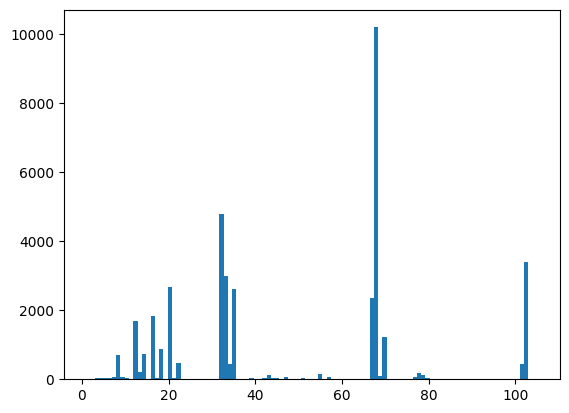

In [36]:

def MostFlower(img):

    compare_db=CompareData(img)
    get_num=compare_db.nsmallest(3,"color_hist_dis",keep='all')
    get_num['num']
    flower_list=[]
    for i in get_num['num']:
        flower_list.append(df['name_En'][int(i)])
    
    maxlabel = max(flower_list,key=flower_list.count)
    max_corr=compare_db["color_hist_corr"].nlargest(3).index
    corr=[]
    for i in max_corr:
        corr.append(df['name_En'][i])
    maxlabel_corr = max(corr,key=corr.count)
    return maxlabel ,flower_list,corr,maxlabel_corr
#print(MostFlower("C:/flowerpic/jpeg-224x224/val/iris/12769.jpeg"))
print(MostFlower("testdata/lilac hibiscus_1.jpeg"))

In [121]:
# def Test(img):
#     maxlabel ,flower_list,corr,maxlabel_corr=MostFlower(img)
#     if maxlabel==maxlabel_corr:
#         flower=maxlabel
#     else:
#         flower="Confusion"
#     return flower
        
    

In [37]:
def Test(img):
    maxlabel ,flower_list,corr,maxlabel_corr=MostFlower(img)
    flower_list.extend(corr)
    maxF = max(flower_list,key=flower_list.count)
    
    return maxF

混淆矩陣+準確度
---

In [17]:
def GetTestName(img):
    img=img
    Split=img.split("/")
    name=Split[1][:-7]
    return name

In [38]:
pathlist = Path("testdata").glob("**/*.jpeg")
flower_correct_name=[]
flower_test_name=[]
for path in pathlist:
    Path_=(str(path).replace('\\','/'))
    name=GetTestName(Path_)
    test=Test(Path_)
    flower_correct_name.append(name)
    flower_test_name.append(test)


: 

In [143]:
from sklearn.metrics import accuracy_score


accuracy = accuracy_score(flower_correct_name, flower_test_name)

print("準確度:", accuracy)
#0.475
#0.525
#0.575
#0.754

準確度: 0.7543859649122807


In [144]:
from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(flower_correct_name, flower_test_name,labels=['balloon flower',
 'bishop of llandaff',
 'black-eyed susan',
 'blanket flower',
 'californian poppy',
 'daisy',
 'giant white arum lily',
 'globe thistle',
 'iris',
 'lilac hibiscus',
 'orange dahlia',
 'osteospermum',
 'pink-yellow dahlia',
 'poinsettia',
 'sunflower',
 'thorn apple',
 'tree mallow',
 'tree poppy',
 'yellow iris',
])

conf_matrix

array([[1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0],
       [0,

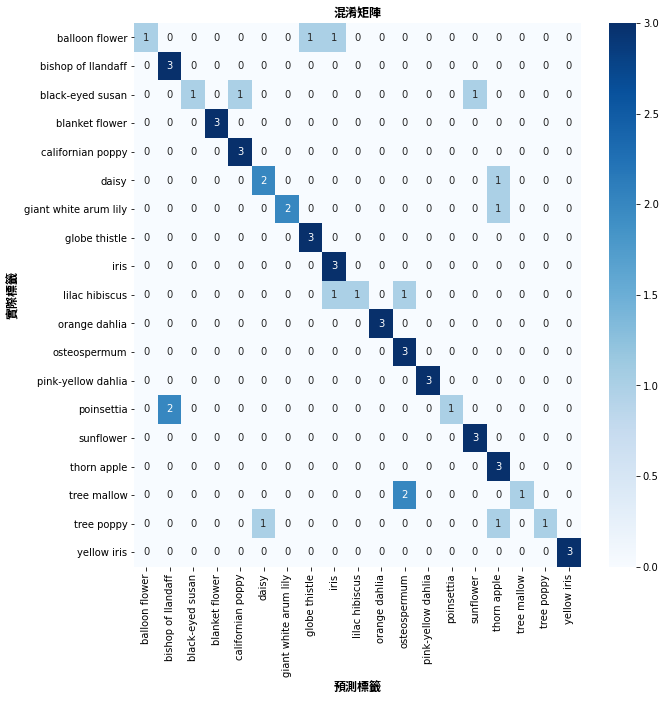

In [145]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from matplotlib.font_manager import FontProperties

name=['balloon flower',
 'bishop of llandaff',
 'black-eyed susan',
 'blanket flower',
 'californian poppy',
 'daisy',
 'giant white arum lily',
 'globe thistle',
 'iris',
 'lilac hibiscus',
 'orange dahlia',
 'osteospermum',
 'pink-yellow dahlia',
 'poinsettia',
 'sunflower',
 'thorn apple',
 'tree mallow',
 'tree poppy',
 'yellow iris',
]
font = FontProperties(fname="NotoSansTC-Bold.ttf", size=12)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=name, yticklabels=name)
plt.xticks(rotation=90)
plt.title("混淆矩陣",font=font)
plt.xlabel("預測標籤",font=font)
plt.ylabel("實際標籤",font=font)
plt.show()

局部特徵
===
小做了一點 還不是很懂 可能要多看一點論文

In [ ]:
import numpy as np
import cv2 
img_1 = cv2.imread('C:/flowerpic/jpeg-224x224/val/iris/12769.jpeg')
img_2 = cv2.imread('C:/flowerpic/jpeg-224x224/val/iris/16301.jpeg')
#gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#sift_1 = cv2.SIFT_create()
#kp_1 = sift_1.detect(img_1,None)
#img_1=cv2.drawKeypoints(img_1,kp_1,img_1,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#sift_2 = cv2.SIFT_create()
#kp_2 = sift_2.detect(img_2,None)
#img_2=cv2.drawKeypoints(img_2,kp_2,img_2,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


#cv2.imshow("SIFT", img_2)
#cv2.waitKey(0)
#cv2.destroyAllWindows()


In [ ]:
img_1 = cv2.imread('C:/flowerpic/jpeg-224x224/val/iris/12769.jpeg')
img_2 = cv2.imread('C:/flowerpic/jpeg-224x224/val/iris/16301.jpeg')
orb = cv2.ORB_create(nfeatures = 50)
kp1_orb, des1_orb = orb.detectAndCompute(img_1,None)
kp2_orb, des2_orb = orb.detectAndCompute(img_2,None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches_orb = bf.match(des1_orb,des2_orb)

img_=cv2.drawKeypoints(img_2,kp2_orb,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv2.imwrite("ORB.jpg", img_)
cv2.imshow("ORB", img_)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
#surf = cv2.SURF_create(40)
img_1 = cv2.imread('C:/flowerpic/jpeg-224x224/val/iris/12769.jpeg')
img_2 = cv2.imread('C:/flowerpic/jpeg-224x224/val/iris/16301.jpeg')
sift = cv2.SIFT_create()

gray_1= cv2.cvtColor(img_1,cv2.COLOR_BGR2GRAY)
gray_2= cv2.cvtColor(img_2,cv2.COLOR_BGR2GRAY)
kp1_sift, des1_sift = sift.detectAndCompute(gray_1,None)
kp2_sift, des2_sift = sift.detectAndCompute(gray_2,None)
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches_sift = bf.match(des1_sift,des2_sift)

img=cv2.drawKeypoints(gray_2,kp2_sift,gray_2,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imwrite("SIFT.jpg", img)
cv2.imshow("SIFT", img)
cv2.waitKey(0)
cv2.destroyAllWindows()




In [ ]:

print("DataType:",type(matches_orb[0]))
print("描述符之間的距離:",matches_orb[0].distance)# 越小越好
print("圖像中描述符的索引:",matches_orb[0].queryIdx)

print("DataType:",type(matches_sift[0]))
print("描述符之間的距離:",matches_sift[0].distance)
print("圖像中描述符的索引:",matches_sift[0].queryIdx)



DataType: <class 'cv2.DMatch'>
描述符之間的距離: 59.0
圖像中描述符的索引: 1
DataType: <class 'cv2.DMatch'>
描述符之間的距離: 198.2296600341797
圖像中描述符的索引: 0


爬蟲
===
確認chrome版本是否為 118.0.5993.70 <br>
不是的話去裝相應版本的driver不然就更新

In [ ]:
def FindPrice(name):
    driver=webdriver.Chrome()
    driver.get("https://m.coa.gov.tw/Transaction/AgriculturalProduct/Index?TcType=N06")
    #MarketId
    #class="multiselect-native-select"
    marked = driver.find_element_by_class_name("multiselect-native-select")
    marked.click()
    time.sleep(1)
    #select = Select(driver.find_element_by_class_name("custom-select"))
    all_select=driver.find_element_by_class_name("checkbox")
    all_select.click()
    time.sleep(1)

    flower_name = driver.find_element_by_id("ByKeyword")
    flower_name.send_keys(f"{name}")
    time.sleep(1)
    button = driver.find_element_by_id("btn-search")
    button.click()
    time.sleep(10)
    
    title={
    "date":[],
    'type':[],
    'id':[],
    'name':[],
    'opt':[],
    'place':[],
    'price_up':[],
    'price_mid':[],
    'price_low':[],
    'price':[],}

    flower_price=pd.DataFrame(title)
    for i in range(2,22):
        try:
            
            x=(driver.find_element_by_xpath(f"/html/body/div[1]/main/div[2]/div/section[2]/table/tbody/tr[{i}]").text)

            X=x.split(" ")
            data={
            "date":X[0],
            'type':X[1],
            'id':X[2],
            'name':X[3],
            'opt':X[4],
            'place':X[5],
            'price_up':X[6],
            'price_mid':X[7],
            'price_low':X[8],
            'price':X[9]}
            flower_price=flower_price.append(data,ignore_index=True)
        except:
            print('no data')
    driver.close()    
    return flower_price


FindPrice("康乃馨")  

,date,type,id,name,opt,place,price_up,price_mid,price_low,price
0,112/10/14,花卉,FA800,康乃馨,多朵(混色),高雄市,43,43,43,43\n-14.0%\n60\n+0.0%
1,112/10/14,花卉,FA800,康乃馨,多朵(混色),台中市,39,39,39,39\n-13.3%\n60\n+0.0%
2,112/10/13,花卉,FA800,康乃馨,多朵(混色),高雄市,50,50,50,50\n+2.0%\n60\n+0.0%
3,112/10/13,花卉,FA800,康乃馨,多朵(混色),台中市,45,45,45,45\n+21.6%\n60\n+0.0%
4,112/10/13,花卉,FA812,康乃馨,波斯桃紅,高雄市,40,40,40,40\n-\n30\n-
5,112/10/12,花卉,IA800,進口康乃馨,多朵混色,溪湖鎮,113,113,113,113\n+3.7%\n144\n+350.0%
6,112/10/12,花卉,IA800,進口康乃馨,多朵混色,台中市,114,114,109,"112.8\n+44.6%\n144\n+1,100.0%"
7,112/10/12,花卉,IA001,進口康乃馨,混合色,高雄市,134,78,77,90\n-29.1%\n138\n+130.0%
8,112/10/12,花卉,IA001,進口康乃馨,混合色,台中市,149,73,71,88\n-38.7%\n138\n+130.0%
9,112/10/12,花卉,IA800,進口康乃馨,多朵混色,高雄市,85,85,85,85\n+0.0%\n108\n-23.9%
